In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
d = h5py.File('./data/electrons-10GeV-incidence-perp.hdf5', 'r')

In [3]:
first = d['layer_0'][:]
second = d['layer_1'][:]
third = d['layer_2'][:]

In [4]:
first.shape

(100000, 3, 96)

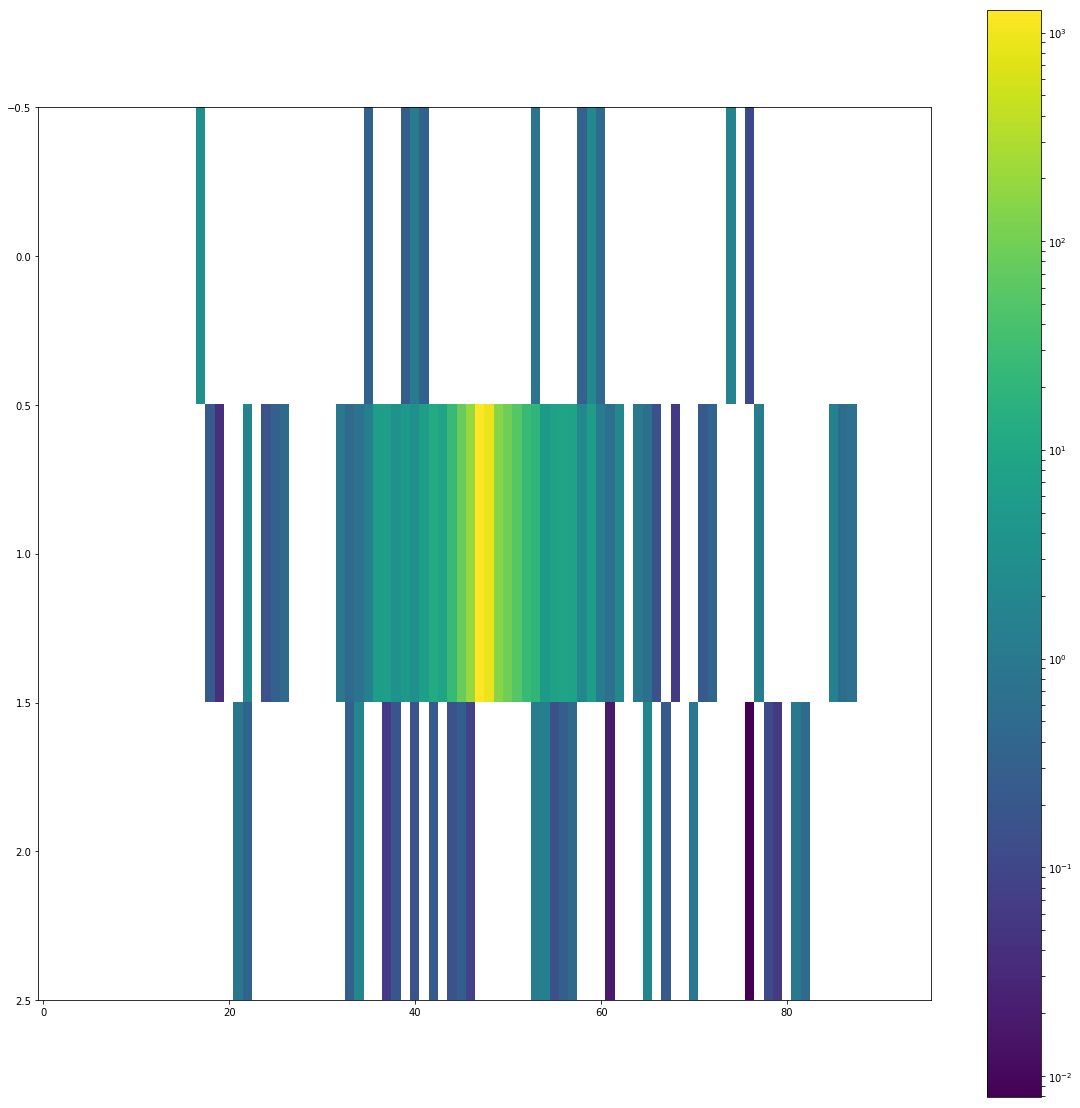

In [5]:
imageix = 0
plt.figure(figsize=(20,20))
plt.imshow(first[imageix], aspect=float(first.shape[2])/first.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()
# aspect is needed to make this 3*96 image come out nice

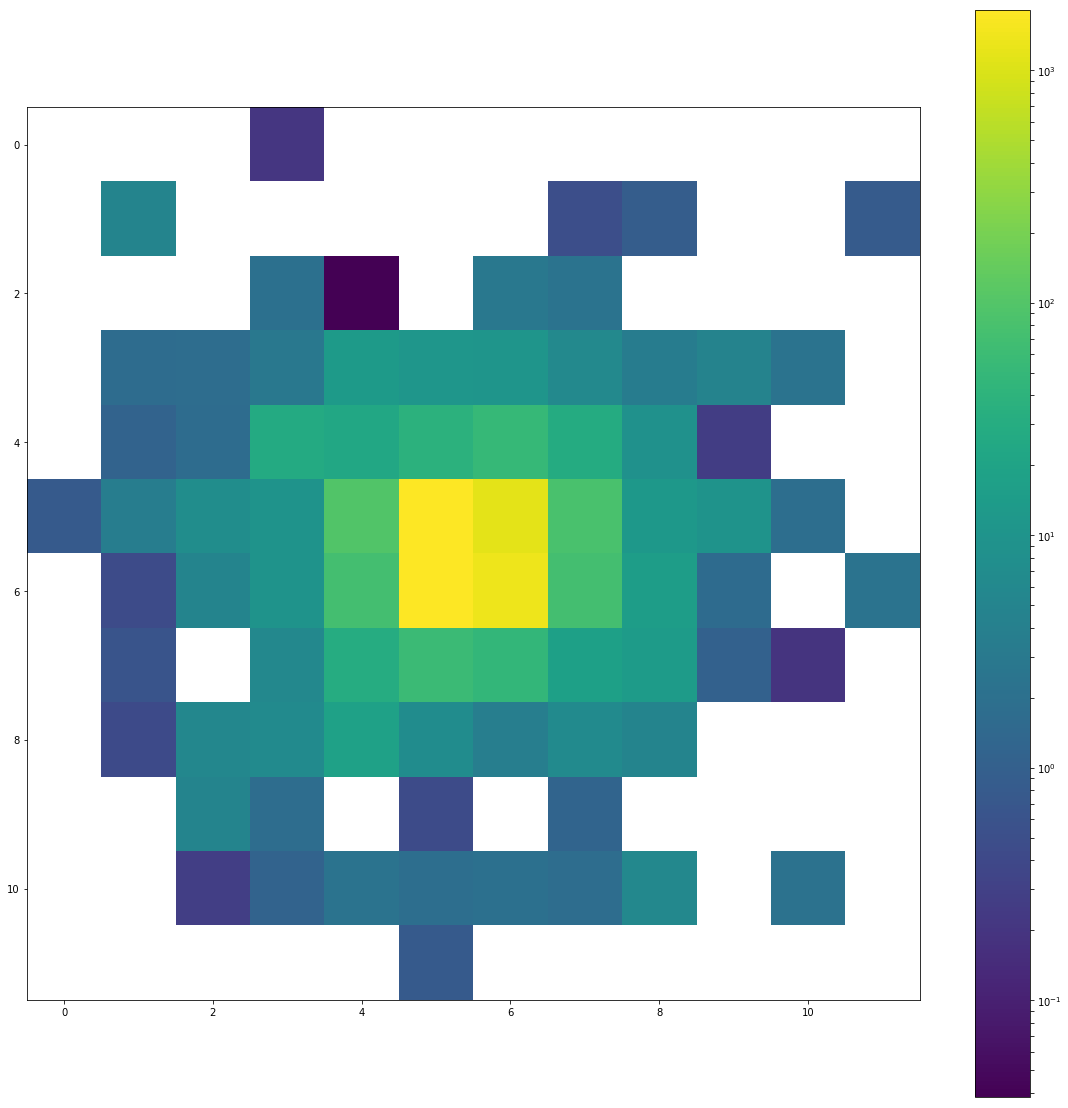

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(second[imageix], aspect=float(second.shape[2])/second.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()

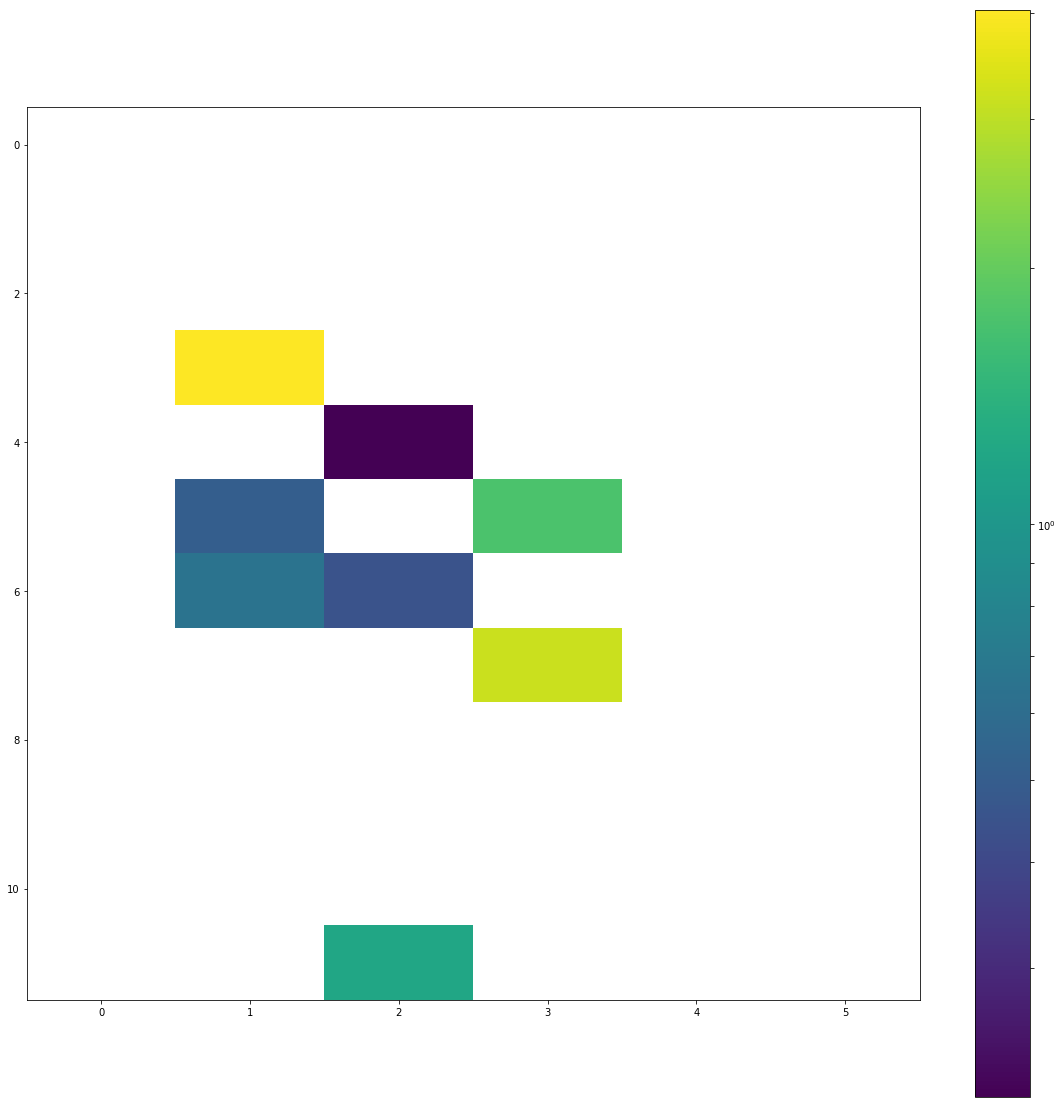

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(third[imageix], aspect=float(third.shape[2])/third.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()

In [5]:
import keras.backend as K
from keras.layers import (Input, Dense, Reshape, Flatten, Embedding, merge,
                          Dropout, BatchNormalization, Activation)

from keras.layers.advanced_activations import LeakyReLU

from keras.layers.local import LocallyConnected2D
from keras.layers.convolutional import UpSampling2D, Conv2D, ZeroPadding2D

from keras.models import Model, Sequential

K.set_image_dim_ordering('tf')


#def generator(latent_size, return_intermediate=False):
def generator(latent_size, img_shape, return_intermediate=False):
    '''
    img_shape = tuple of image eta-phi dimensions (e.g. (3, 96))
    '''

    z = Input(shape=(latent_size, ))

    # DCGAN-style project & reshape,
    #x = Dense(5 * 98 * 12, input_dim=latent_size)(z)
    #x = Reshape((5, 98, 12))(x)
    x = Dense((img_shape[0] + 2) * (img_shape[1] + 2) * 12, input_dim=latent_size)(z)
    x = Reshape((img_shape[0] + 2, img_shape[1] + 2, 12))(x)

    # block 1: (None, 5, 98, 12) => (None, 5, 98, 8),
    x = Conv2D(8, (2, 2), padding='same', kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    # block 2: (None, 5, 98, 32) => (None, 4, 97, 6),
    #ZeroPadding2D((2, 2)),
    x = LocallyConnected2D(6, (2, 2), kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
            
    # block 3: (None, 4, 97, 6) => (None, 3, 96, 1),
    x = LocallyConnected2D(1, (2, 2), use_bias=False, kernel_initializer='glorot_normal')(x)
    y = Activation('relu')(x)
    
    return Model(z, y)

Using TensorFlow backend.


In [6]:
noise = np.random.normal(0, 1, (50000, 500))

In [7]:
G = generator(500, (12, 12))

In [14]:
G.load_weights('./weights/params_generator_epoch_049_b2.hdf5')

In [15]:
images = G.predict(noise, verbose=True)

49920/50000 [============================>.] - ETA: 0s 

In [16]:
images *= 500

In [17]:
images = np.squeeze(images)

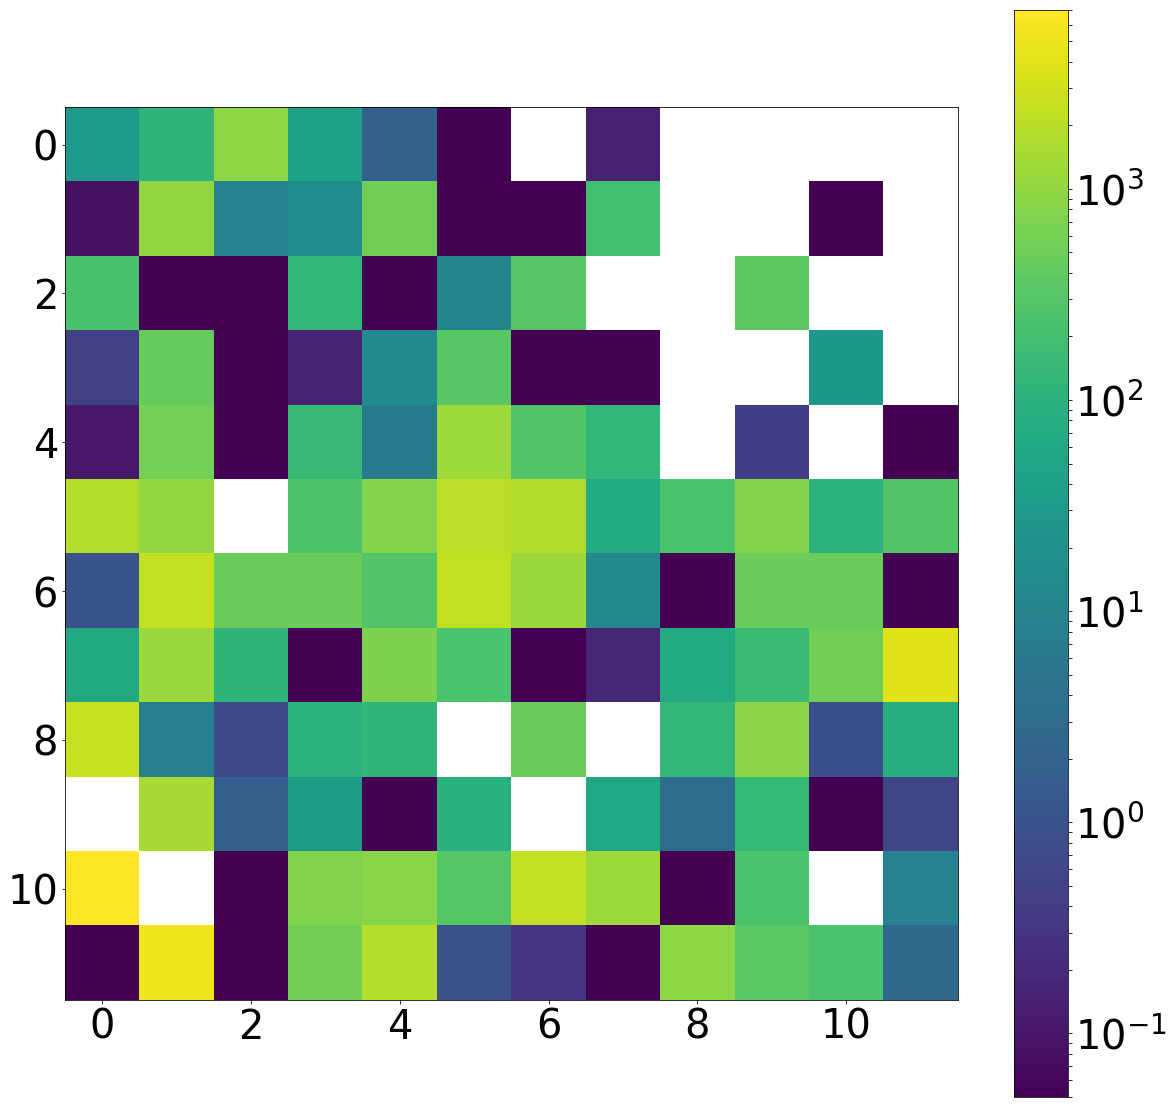

In [18]:
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(images.mean(axis=0), #aspect=float(first.shape[2])/first.shape[1], 
           interpolation='nearest', norm=LogNorm(vmin=second.mean(axis=0).min()))
plt.colorbar()

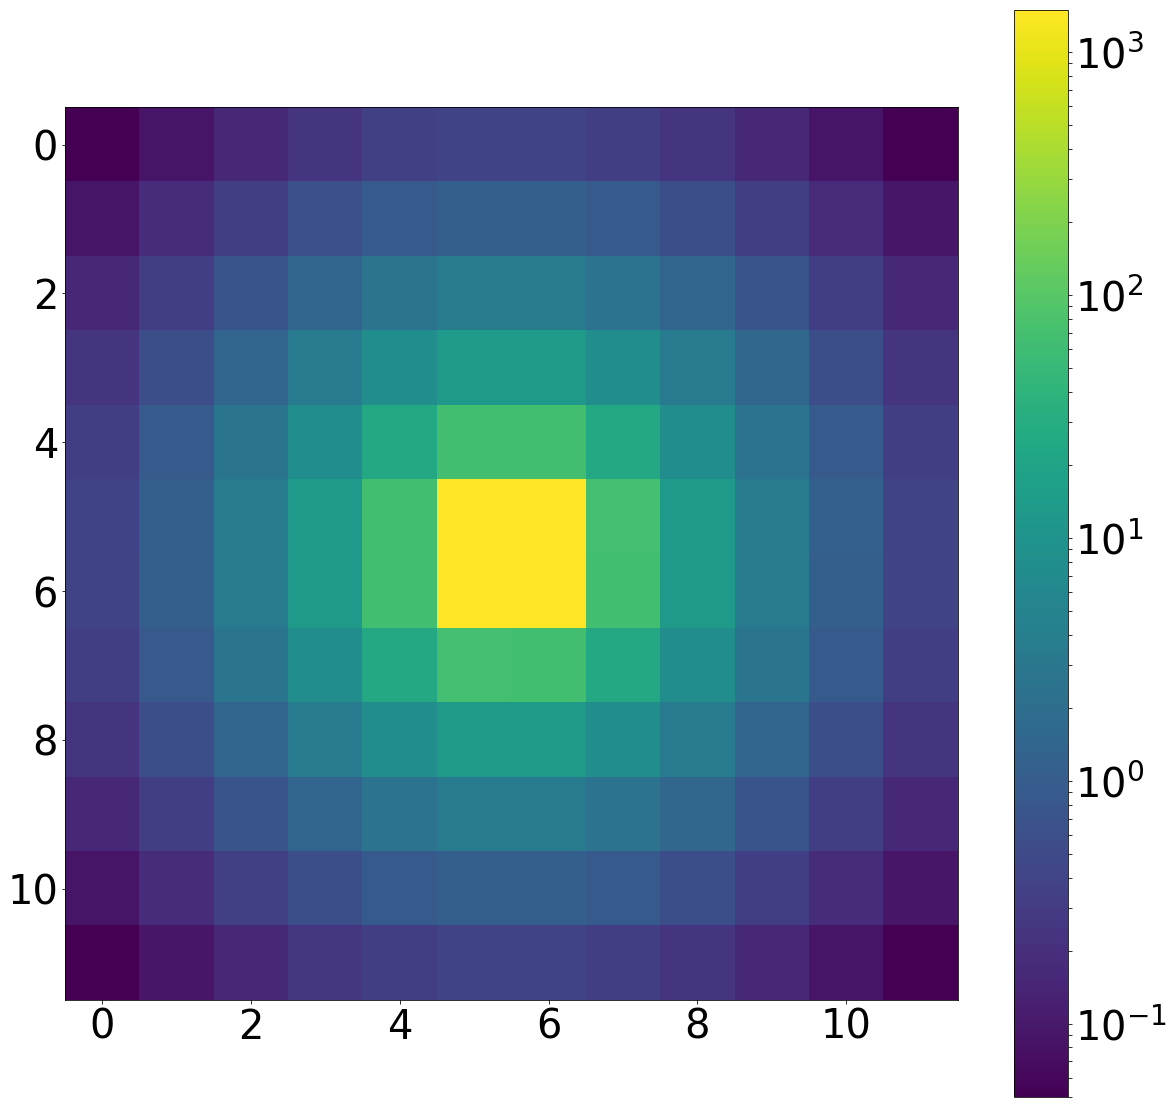

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(second.mean(axis=0), interpolation='nearest', norm=LogNorm())
plt.colorbar()

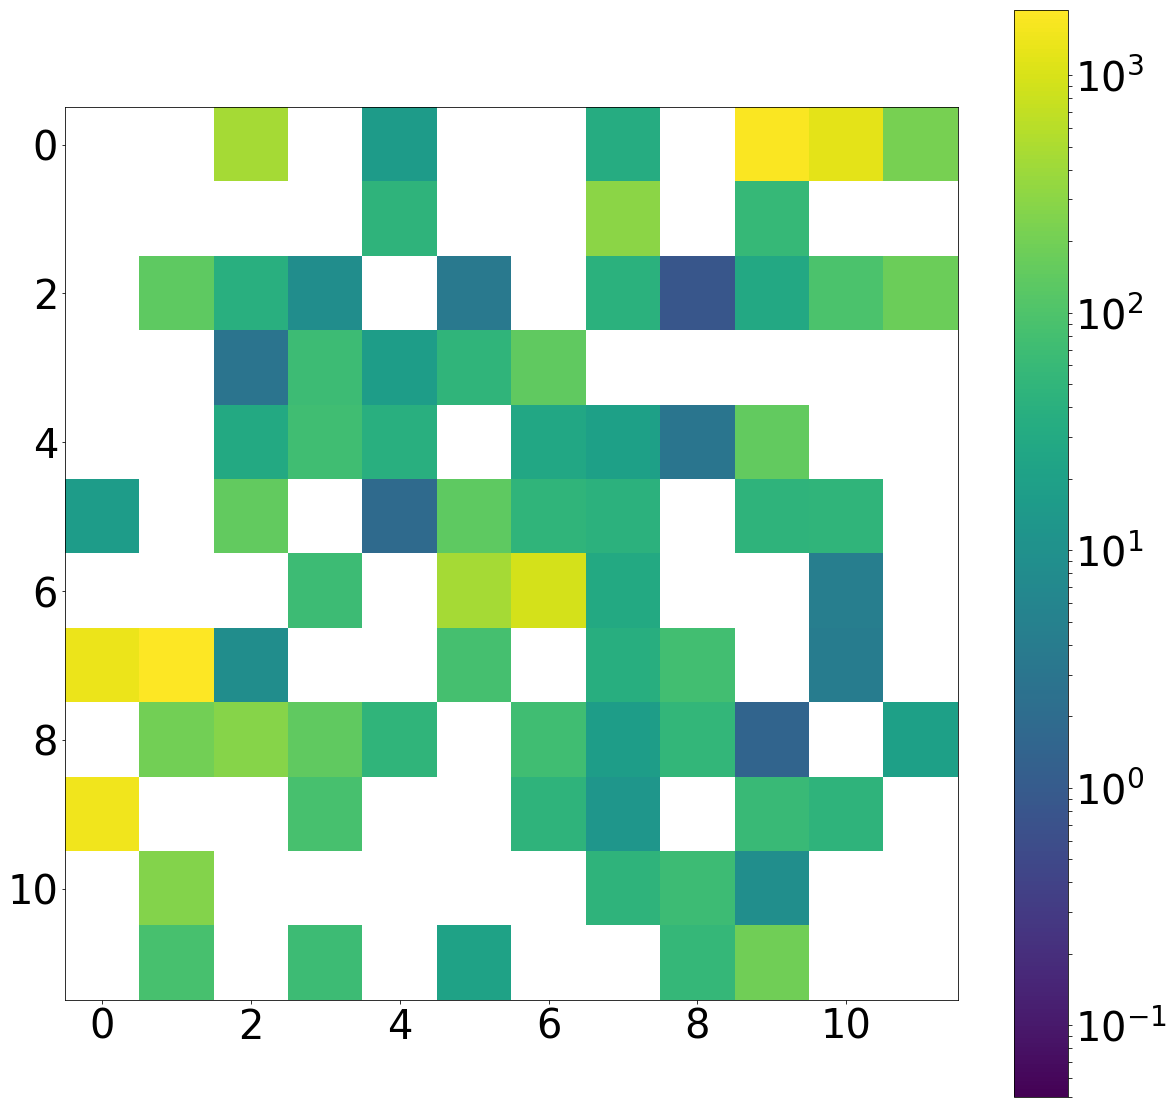

In [13]:
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(images[110], interpolation='nearest', norm=LogNorm(vmin=second.mean(axis=0).min()))
plt.colorbar()

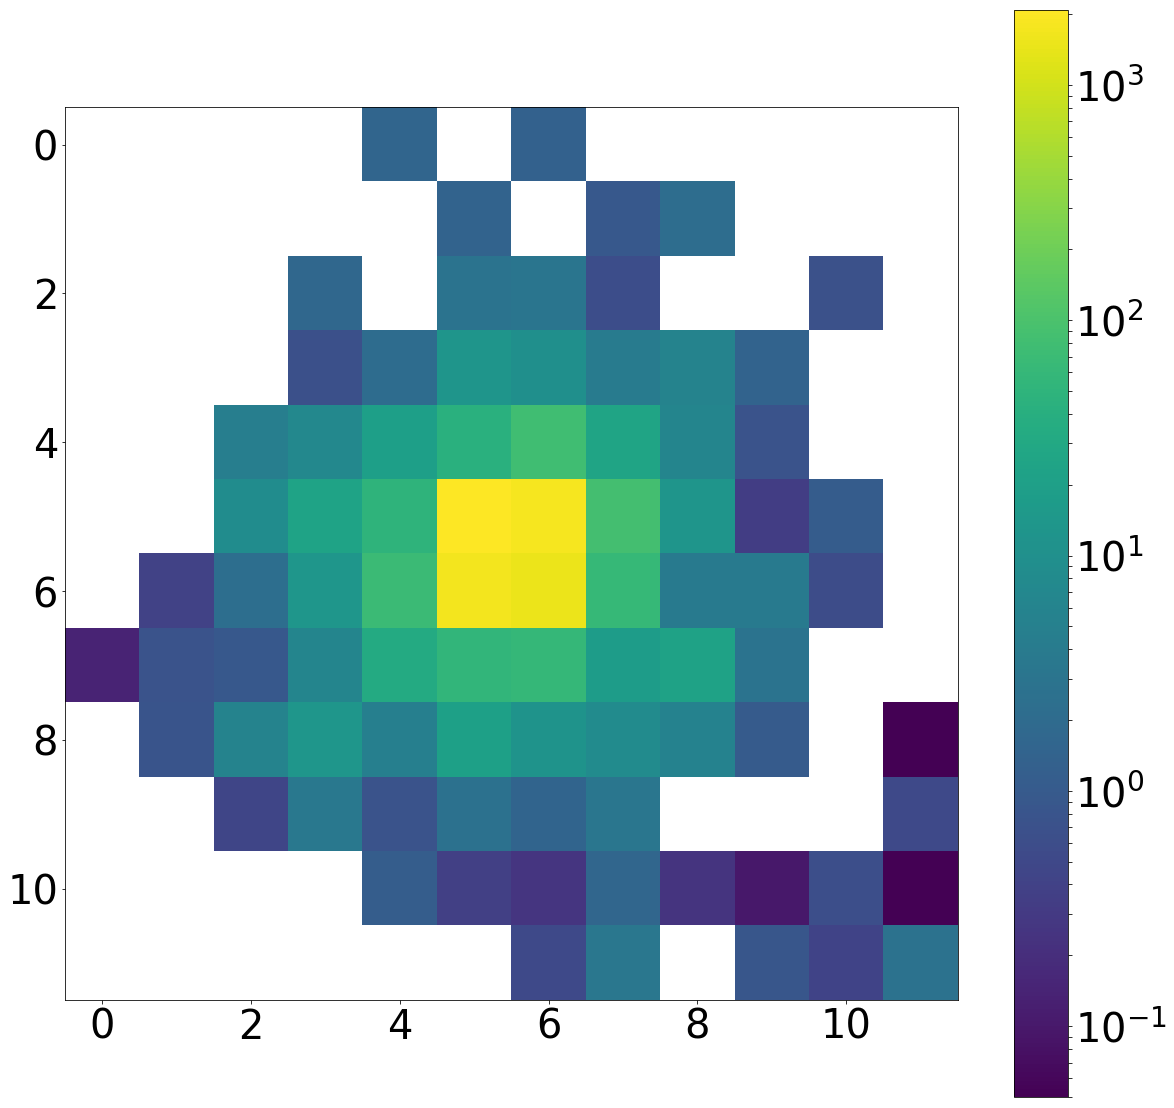

In [35]:
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(second[110], interpolation='nearest', norm=LogNorm(vmin=second.mean(axis=0).min()))
plt.colorbar()